# Question 3

This script demonstrates heterodyning as part of a polyphase interpolator.

In [2]:
from pathlib import Path

import numpy as np
import scipy.fft as fft
import scipy.signal as signal

import matplotlib.pyplot as plt
import seaborn as sns

from a3_config import A3_ROOT, SAVEFIG_CONFIG

### Construct Kaiser LPF

In [3]:
FS     = 0.5    # sampling frequency, kHz
F_PASS = 0.2    # cutoff frequency, kHz
F_STOP = 0.3    # stop band frequency, kHz
A_PASS = 3      # pass band attenuation, dB
A_STOP = 100    # stop band attenuation, dB

In [4]:
ripple_p = 1 - np.power(10, -A_PASS / 20)
ripple_s = np.power(10, -A_STOP / 20)
print("Maximum pass band ripple:", ripple_p)
print("Maximum stop band ripple:", ripple_s)

A = -20 * np.log10(min(ripple_p, ripple_s))
print("Required attenuation:", A, "dB")

Maximum pass band ripple: 0.2920542156158621
Maximum stop band ripple: 1e-05
Required attenuation: 100.0 dB


In [5]:
# Kaiser window filter length estimate
N = int(np.ceil((A - 7.95)/(14.36 * ((F_STOP - F_PASS) / (FS * 80)))))
N = N + 1 if (N % 2) else N
print("Filter length estimate:", N)

beta = 0.1102 * (A - 8.7)
print("Kaiser window beta:", beta)

Filter length estimate: 2566
Kaiser window beta: 10.06126


Construct a vector representing the ideal frequency response.

In [6]:
# Calculate pass band width, L
_L = int(np.round(N * F_PASS / (FS * 80)))
print("Bins in passband:", _L)

# Construct V, with 1's in the pass band and 0's in the stop band
h_ideal = np.zeros(N//2)
h_ideal[:_L] = np.ones(_L)
h_ideal = np.concatenate([h_ideal, np.flip(h_ideal)])

# Impulse (time) response of ideal filter
x_ideal = fft.fftshift(fft.ifft(h_ideal))

# Construct and apply the Kaiser window
x_windowed = x_ideal * signal.windows.kaiser(N, beta)
h_windowed = fft.fft(x_windowed, 512)[:256]

Bins in passband: 13


### Polyphase Upsample & Heterodyne

In [7]:
# Import polyphase downsampled signal from Question 1
t_signal, x_signal = np.load(Path(A3_ROOT, "output", "q1_signal_out.npy"))

In [25]:
L = 80          # upsampling rate, equal to M determined in Question 3
F_CARRIER = 10  # kHz, frequency shift

# Reshape filter coefficients into matrix, zero padded to multiple of L
Z = L - (N % L)
polyfilt = np.concatenate([x_windowed, np.zeros(Z)])
polyfilt = polyfilt.reshape(int((N + Z) / L), L).T  # reshape row-major then transpose

# Apply heterodyning (frequency shifting) w/ 10 kHz carrier
k = F_CARRIER / FS
for i in range(L):
    polyfilt[i] *= np.cos(2 * np.pi * i * k / L)

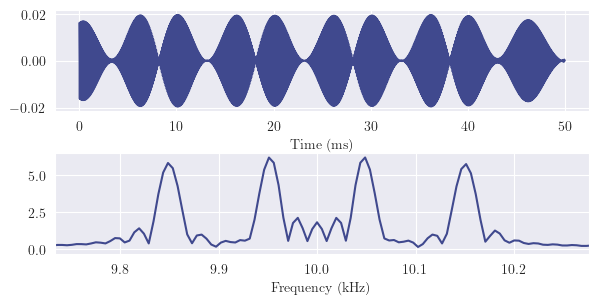

In [29]:
# Concatenate results into output array, which becomes the filtered signal
x_polyfilt = []
for i in range(L):
    x_polyfilt.append(signal.convolve(polyfilt[i], x_signal))
x_polyfilt = np.array(x_polyfilt).flatten("F")

# As before, remove transient edge effects
x_polyfilt = x_polyfilt[(N+Z-L)//2:-(N+Z-L)//2]

# Plot the polyphase downsampled signal
h_polyfilt = fft.fft(x_polyfilt, 8192)[:4096]

t_polyfilt = np.arange(0, 50, 50 / len(x_polyfilt))
f_polyfilt = fft.fftfreq(8192, 50 / len(x_polyfilt))[:4096]

fig, axs = plt.subplots(2, figsize=(6, 3))
fig.tight_layout()

sns.lineplot(x=t_polyfilt, y=x_polyfilt.real, ax=axs[0])
sns.lineplot(x=f_polyfilt, y=np.abs(h_polyfilt), ax=axs[1])

axs[0].set_xlabel("Time (ms)")
axs[1].set_xlabel("Frequency (kHz)")
axs[1].set_xlim([9.734, 10.276])

# fname = Path(A3_ROOT, "output", "q3_heterodyne.png")
# fig.savefig(fname, **SAVEFIG_CONFIG)
plt.show()